In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\NCI Cell Lines\\Carboplatin_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,Carboplatin
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,0.611724
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,0.705000


In [3]:
#drop the target drug column
drug = data.pop('Carboplatin')

In [4]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [5]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [6]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [7]:
X.shape, y.shape

((49, 2181), (49,))

In [8]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    38
1    11
dtype: int64

In [9]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [10]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,PIP2(16:0/18:1(11Z)) ; PIP2(16:0/18:1(9Z)) ; PIP2(16:1(9Z)/18:0) ; PIP2(18:0/16:1(9Z)) ; PIP2(18:1(11Z)/16:0) ; PIP2(18:1(9Z)/16:0),"TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z))
0,-0.004968,-0.558706,0.047015,0.033447,1.342914,2.538730,1.907405,-1.558905,-0.616311,-0.547796,...,0.474461,-0.215228,0.466577,0.239062,0.140676,0.934345,0.32128,-0.452997,0.062768,0.081321
1,-1.330777,-0.380638,-0.981425,-0.906615,-0.545166,-0.919843,-0.106589,-0.870092,-0.216466,-0.794848,...,-0.782993,-0.555141,-0.840627,-1.160089,-1.938762,-1.069101,-0.61024,-1.891483,-1.653379,-0.408236


In [11]:
X.shape, y.shape

((76, 2181), (76,))

In [12]:
y.value_counts()

1    38
0    38
dtype: int64

In [13]:
X.shape

(76, 2181)

In [14]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.33, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [36]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced', random_state = i)
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the machine learning model and train it
    model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced', random_state = i)
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 398
Number of features selected during iteration 1: 407
Number of features selected during iteration 2: 421
Number of features selected during iteration 3: 412
Number of features selected during iteration 4: 397
Number of features selected during iteration 5: 397
Number of features selected during iteration 6: 411
Number of features selected during iteration 7: 435
Number of features selected during iteration 8: 399
Number of features selected during iteration 9: 402
Number of features selected during iteration 10: 403
Number of features selected during iteration 11: 399
Number of features selected during iteration 12: 385
Number of features selected during iteration 13: 407
Number of features selected during iteration 14: 413
Number of features selected during iteration 15: 408
Number of features selected during iteration 16: 422
Number of features selected during iteration 17: 402
Number of features selected during iteration 18: 413
Num

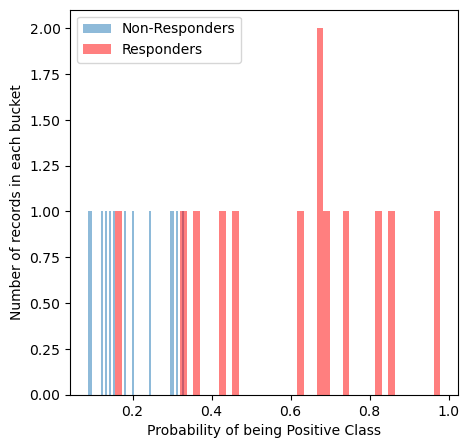

In [37]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [38]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [39]:
df1

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
0,-0.004968,-0.558706,0.047015,0.033447,1.342914,2.538730,1.907405,-1.558905,-0.616311,-0.547796,...,0.466577,0.239062,0.140676,0.934345,0.321280,-0.452997,0.062768,0.081321,0.676933,1.0
1,-1.330777,-0.380638,-0.981425,-0.906615,-0.545166,-0.919843,-0.106589,-0.870092,-0.216466,-0.794848,...,-0.840627,-1.160089,-1.938762,-1.069101,-0.610240,-1.891483,-1.653379,-0.408236,NaN,NaN
2,1.076465,-0.521529,2.323191,2.299990,0.782046,-0.003662,0.346771,-0.324092,-0.620685,-0.833219,...,-0.055434,-0.545093,0.145479,-1.147283,0.536577,0.069168,-0.157811,0.180650,NaN,NaN
3,-1.571923,-0.683823,-1.640971,-1.548244,-1.799310,-1.280279,-1.052229,1.248556,0.097983,-0.189971,...,0.980400,-0.030018,-0.478705,1.388813,-0.597516,-0.512489,0.087456,0.241821,NaN,NaN
4,-1.080416,-1.297342,-0.141604,-0.162258,-1.825854,-0.906105,-0.222192,0.279747,-0.120790,-0.528009,...,0.176883,-1.910296,-1.510569,-0.795133,-1.490468,-1.773775,-1.823683,-0.474083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.087511,1.165647,-0.704104,-0.587763,0.712010,-0.382568,-0.755043,0.863242,-0.428918,1.030094,...,-0.015389,0.074064,0.049933,0.175907,-0.286141,-0.096566,0.505460,-0.265635,0.691600,1.0
72,-1.066650,-0.418968,-0.824174,-0.754380,-0.409287,-0.659531,0.109038,-0.836624,-0.241448,-0.824227,...,-0.763321,-0.887992,-1.600586,-0.776700,-0.497247,-1.665705,-1.319935,-0.325539,NaN,NaN
73,1.206864,0.620538,0.199583,0.251334,0.417020,1.160962,0.986349,-0.464973,-0.467624,-0.673959,...,0.112829,0.429315,0.478821,0.934546,1.388336,0.344683,0.719421,0.918948,0.678667,1.0
74,0.356230,-0.565665,1.245128,1.253454,0.080040,-0.350841,-0.033690,0.103593,-0.425242,-0.658286,...,0.226263,-0.405017,-0.024269,-0.457586,0.228158,-0.089015,-0.091110,0.197286,NaN,NaN


In [40]:
df1_main = df1.iloc[:49, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 2183)

In [41]:
df1_main.index.values #0 40 41 42

array([ 0, 41, 42], dtype=int64)

In [43]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store accuracy, precision and recall 
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = SVC(kernel = 'linear', C=1, gamma=1, probability = True, random_state = i)
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.coef_.ravel()
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the SVM model and train it
    model2 = SVC(C=1, gamma=1, probability=True, random_state = i)
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 2181
Features selected during iteration 1: 2181
Features selected during iteration 2: 2181
Features selected during iteration 3: 2181
Features selected during iteration 4: 2181
Features selected during iteration 5: 2181
Features selected during iteration 6: 2181
Features selected during iteration 7: 2181
Features selected during iteration 8: 2181
Features selected during iteration 9: 2181
Features selected during iteration 10: 2181
Features selected during iteration 11: 2181
Features selected during iteration 12: 2181
Features selected during iteration 13: 2181
Features selected during iteration 14: 2181
Features selected during iteration 15: 2181
Features selected during iteration 16: 2181
Features selected during iteration 17: 2181
Features selected during iteration 18: 2181
Features selected during iteration 19: 2181
Features selected during iteration 20: 2181
Features selected during iteration 21: 2181
Features selected during iteration 22: 218

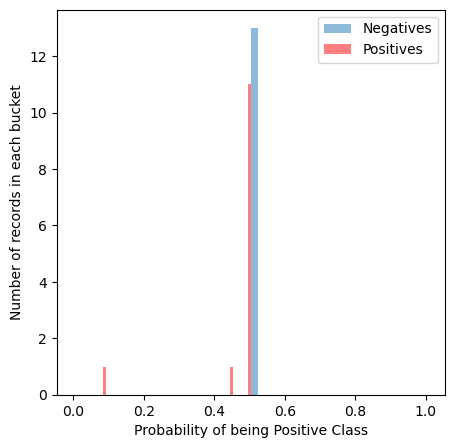

In [44]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [45]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [46]:
df2_main = df2.iloc[:49, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target


In [47]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [48]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier(seed = i)
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define XGBoost model and train it
    model3 = XGBClassifier(seed = i)
    model3.fit(X_train, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 15
Features selected during iteration 1: 15
Features selected during iteration 2: 15
Features selected during iteration 3: 15
Features selected during iteration 4: 15
Features selected during iteration 5: 15
Features selected during iteration 6: 15
Features selected during iteration 7: 15
Features selected during iteration 8: 15
Features selected during iteration 9: 15
Features selected during iteration 10: 15
Features selected during iteration 11: 15
Features selected during iteration 12: 15
Features selected during iteration 13: 15
Features selected during iteration 14: 15
Features selected during iteration 15: 15
Features selected during iteration 16: 15
Features selected during iteration 17: 15
Features selected during iteration 18: 15
Features selected during iteration 19: 15
Features selected during iteration 20: 15
Features selected during iteration 21: 15
Features selected during iteration 22: 15
Features selected during iteration 23: 15
Fe

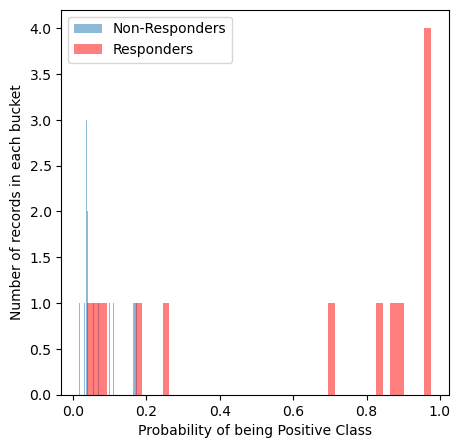

In [49]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [50]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
0,-0.004968,-0.558706,0.047015,0.033447,1.342914,2.538730,1.907405,-1.558905,-0.616311,-0.547796,...,0.466577,0.239062,0.140676,0.934345,0.321280,-0.452997,0.062768,0.081321,0.249865,1.0
1,-1.330777,-0.380638,-0.981425,-0.906615,-0.545166,-0.919843,-0.106589,-0.870092,-0.216466,-0.794848,...,-0.840627,-1.160089,-1.938762,-1.069101,-0.610240,-1.891483,-1.653379,-0.408236,NaN,NaN
2,1.076465,-0.521529,2.323191,2.299990,0.782046,-0.003662,0.346771,-0.324092,-0.620685,-0.833219,...,-0.055434,-0.545093,0.145479,-1.147283,0.536577,0.069168,-0.157811,0.180650,NaN,NaN
3,-1.571923,-0.683823,-1.640971,-1.548244,-1.799310,-1.280279,-1.052229,1.248556,0.097983,-0.189971,...,0.980400,-0.030018,-0.478705,1.388813,-0.597516,-0.512489,0.087456,0.241821,NaN,NaN
4,-1.080416,-1.297342,-0.141604,-0.162258,-1.825854,-0.906105,-0.222192,0.279747,-0.120790,-0.528009,...,0.176883,-1.910296,-1.510569,-0.795133,-1.490468,-1.773775,-1.823683,-0.474083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.087511,1.165647,-0.704104,-0.587763,0.712010,-0.382568,-0.755043,0.863242,-0.428918,1.030094,...,-0.015389,0.074064,0.049933,0.175907,-0.286141,-0.096566,0.505460,-0.265635,0.961475,1.0
72,-1.066650,-0.418968,-0.824174,-0.754380,-0.409287,-0.659531,0.109038,-0.836624,-0.241448,-0.824227,...,-0.763321,-0.887992,-1.600586,-0.776700,-0.497247,-1.665705,-1.319935,-0.325539,NaN,NaN
73,1.206864,0.620538,0.199583,0.251334,0.417020,1.160962,0.986349,-0.464973,-0.467624,-0.673959,...,0.112829,0.429315,0.478821,0.934546,1.388336,0.344683,0.719421,0.918948,0.826431,1.0
74,0.356230,-0.565665,1.245128,1.253454,0.080040,-0.350841,-0.033690,0.103593,-0.425242,-0.658286,...,0.226263,-0.405017,-0.024269,-0.457586,0.228158,-0.089015,-0.091110,0.197286,NaN,NaN


In [51]:
df3_main = df3.iloc[:49, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
0,-0.004968,-0.558706,0.047015,0.033447,1.342914,2.538730,1.907405,-1.558905,-0.616311,-0.547796,...,0.466577,0.239062,0.140676,0.934345,0.321280,-0.452997,0.062768,0.081321,0.249865,1.0
41,0.156948,-0.201533,0.784692,0.773361,0.002762,0.117213,-0.087058,-0.338869,-0.463131,1.012679,...,1.731658,1.350265,0.971633,-0.509007,0.799073,0.752025,1.153543,1.184592,0.864404,1.0


In [52]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [53]:
cl = set(common_list)
cl

{0, 41, 42}

In [54]:
df1_total = df1.loc[:49, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
0,-0.004968,-0.558706,0.047015,0.033447,1.342914,2.538730,1.907405,-1.558905,-0.616311,-0.547796,...,0.466577,0.239062,0.140676,0.934345,0.321280,-0.452997,0.062768,0.081321,0.676933,1.0
40,-0.452236,1.891948,-1.154599,-1.149388,-0.864397,-1.176824,-0.736456,0.369869,1.348104,-0.634291,...,-1.459605,-1.254231,-1.111447,-1.251822,-1.414405,-1.323754,-1.164199,-1.435902,0.155600,1.0
41,0.156948,-0.201533,0.784692,0.773361,0.002762,0.117213,-0.087058,-0.338869,-0.463131,1.012679,...,1.731658,1.350265,0.971633,-0.509007,0.799073,0.752025,1.153543,1.184592,0.738133,1.0
42,1.300536,-0.762498,0.585161,0.609994,0.808502,1.673467,2.041554,-0.536676,-0.465345,-1.087536,...,-0.070480,1.550624,1.430257,1.843887,0.515436,0.357794,1.668494,0.415617,0.334667,1.0


In [55]:
with open('master_list_metabolomics.txt', 'w') as f:
    for i in cl:
        f.write(f'{i}\n')

In [56]:
l = []
l.extend(df1_total.index.values)
with open('total_metabolomics.txt', 'w') as f:
    for i in l:
        f.write(f'{i}\n')